In [1]:
import os
from sqlalchemy import create_engine, inspect
import pandas as pd

# Construire le chemin absolu vers la base de données
BASE_DIR = os.getcwd()  # Répertoire courant pour un notebook Jupyter
DB_PATH = os.path.join(BASE_DIR, "..", "database", "energy_consumption.db")
DATABASE_URL = f"sqlite:///{DB_PATH}"

# Connexion à la base SQLite
engine = create_engine(DATABASE_URL)

# Inspecter la base pour récupérer les noms des tables
inspector = inspect(engine)
tables = inspector.get_table_names()

# Charger toutes les tables en un seul appel
df = {table: pd.read_sql_table(table, engine) for table in tables}

# Vérifier les premières lignes de chaque table (optionnel)
for table_name, dataframe in df.items():
    print(f"Table: {table_name}")
    print(dataframe.head(), "\n")

# Fusionner automatiquement les tables en fonction des relations définies
df_complete = df["consommation"] \
    .merge(df["commune"], on="id_commune", how="left") \
    .merge(df["departement"], on="id_departement", how="left") \
    .merge(df["region"], on="id_region", how="left") \
    .merge(df["zone_climatique"], on="id_zone_climatique", how="left") \
    .merge(df["vecteur_energie"], on="id_vecteur_energie", how="left")

# Afficher les premières lignes du DataFrame final
print(df_complete.head())

Table: commune
   id_commune   nom_commune  id_departement
0           1  BAIE MAHAULT               1
1           2       BAILLIF               1
2           3   BASSE TERRE               1
3           4    LES ABYMES               1
4           5   PETIT BOURG               1 

Table: consommation
   id_consommation annee_consommation  surface_declaree  nombre_declaration  \
0                1               2021            205643                  86   
1                2               2021              8815                   7   
2                3               2021              4024                   4   
3                4               2021             88040                  34   
4                5               2021             14890                  13   

   consommation_declaree  densite_energetique   latitude  longitude  \
0               38442621           186.938632  16.267946 -61.587077   
1                1287317           146.037096  16.022508 -61.745402   
2          

In [2]:
df_complete.to_csv("df_models.csv", index="False")

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Charger le df complet
df = pd.read_csv("df_models.csv")
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
df = df.loc[:, ~df.columns.str.contains('^id_')]

#Supprimer les colonnes inutiles pour les modèles
df = df.drop(columns=["nombre_declaration", "nom_commune", "nom_departement", "nom_region"])

# Séparer les features et la cible
X = df.drop(columns=["consommation_declaree", "consommation_log"])
y = df["consommation_log"]

# Diviser en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"X_train: ", X_train.shape)
print(f"X_train: ", X_train.head())
print(f"X_test: ", X_test.shape)
print(f"X_test: ", X_test.head())
print(f"y_train: ", y_train.shape)
print(f"y_train: ", y_train.head())
print(f"y_test: ", y_test.shape)
print(f"y_test: ", y_test.head())

X_train:  (719, 8)
X_train:       annee_consommation  surface_declaree  densite_energetique   latitude  \
798                2020              5629           111.391011  43.792174   
536                2021               608            57.233553  48.119780   
753                2022             52775            44.475168  43.273316   
390                2021             83050           105.567863   4.937154   
118                2021              1156            48.611592  44.606556   

     longitude consommation_etat zone_climatique vecteur_energie  
798   2.133965           Normale             H1b     Electricite  
536  -1.603883           Normale              H3     Electricite  
753   0.851408           Normale             REU     Electricite  
390 -52.325874           Normale             GUY     Electricite  
118  -0.553385           Normale             H2c     Electricite  
X_test:  (180, 8)
X_test:       annee_consommation  surface_declaree  densite_energetique   latitude  \
33

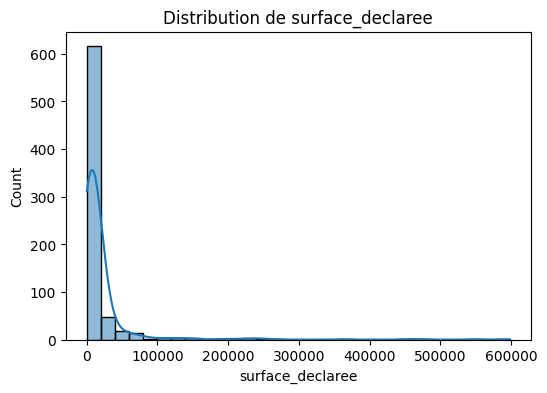

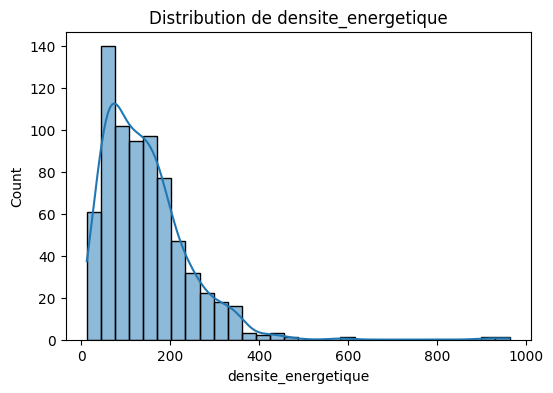

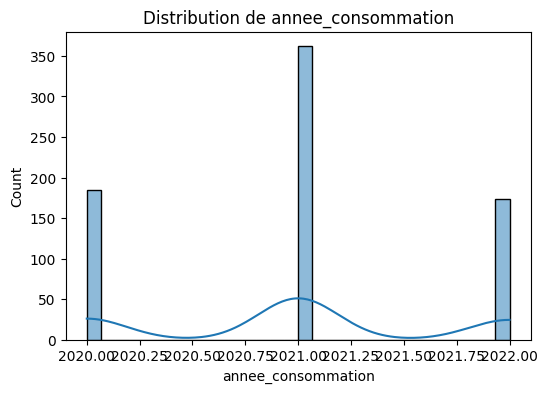

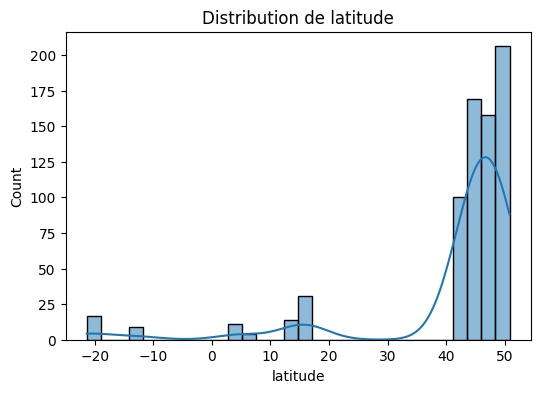

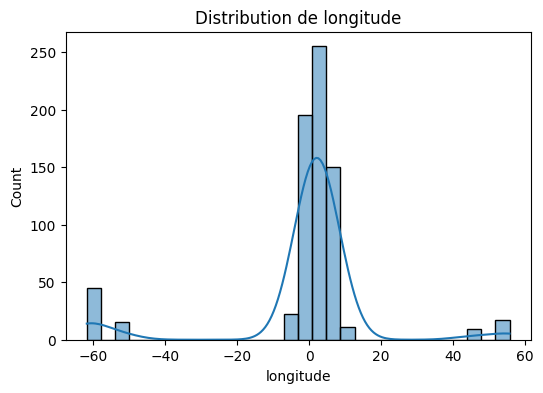

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

# Colonnes numériques à analyser
cols_to_analyze = ["surface_declaree", "densite_energetique", "annee_consommation", "latitude", "longitude"]
                   # ,"ratio_declaration_consommation", "nombre_declaration"]

# Visualisation
for col in cols_to_analyze:
    plt.figure(figsize=(6, 4))
    sns.histplot(X_train[col], kde=True, bins=30)
    plt.title(f"Distribution de {col}")
    plt.show()

In [ ]:
# from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
# import pandas as pd

# # Initialiser les encodeurs et le scaler
# ohe = OneHotEncoder(drop=None, sparse_output=False, handle_unknown="ignore")
# nrm = MinMaxScaler()

# # Définir les colonnes
# col_ohe = ["annee_consommation", "consommation_etat", "nom_commune", "nom_departement", "nom_region", "zone_climatique", "vecteur_energie"]
# col_nrm = ["surface_declaree", "nombre_declaration", "densite_energetique", "ratio_declaration_consommation"]

# # Application du OneHotEncoding
# ohe_train = ohe.fit_transform(X_train[col_ohe])
# ohe_test = ohe.transform(X_test[col_ohe])

# # Ajouter les colonnes encodées au DataFrame
# ohe_columns = ohe.get_feature_names_out(col_ohe)
# X_train_encoded = pd.DataFrame(ohe_train, columns=ohe_columns, index=X_train.index)
# X_test_encoded = pd.DataFrame(ohe_test, columns=ohe_columns, index=X_test.index)

# # Concaténer avec les autres colonnes
# X_train = pd.concat([X_train.drop(columns=col_ohe), X_train_encoded], axis=1)
# X_test = pd.concat([X_test.drop(columns=col_ohe), X_test_encoded], axis=1)

# # Application de la Normalisation MinMaxScaler
# X_train[col_nrm] = nrm.fit_transform(X_train[col_nrm])
# X_test[col_nrm] = nrm.transform(X_test[col_nrm])

# # Afficher les résultats
# print(X_train.shape)
# print(X_train.head())
# print(X_test.shape)
# print(X_test.head())

In [7]:
"""
Encapsulation du pipeline d'encodage et de scaling dans une fonction pour simplifier son utilisation
"""
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler

def preprocess_data(X_train, X_test, col_ohe, col_nrm):
    # Initialiser les encodeurs et le scaler
    ohe = OneHotEncoder(drop=None, sparse_output=False, handle_unknown="ignore")
    nrm = MinMaxScaler()

    # OneHotEncoding
    ohe_train = ohe.fit_transform(X_train[col_ohe])
    ohe_test = ohe.transform(X_test[col_ohe])
    ohe_columns = ohe.get_feature_names_out(col_ohe)

    # Ajouter les colonnes encodées
    X_train_encoded = pd.DataFrame(ohe_train, columns=ohe_columns, index=X_train.index)
    X_test_encoded = pd.DataFrame(ohe_test, columns=ohe_columns, index=X_test.index)

    X_train = pd.concat([X_train.drop(columns=col_ohe), X_train_encoded], axis=1)
    X_test = pd.concat([X_test.drop(columns=col_ohe), X_test_encoded], axis=1)

    # MinMax Scaling
    X_train[col_nrm] = nrm.fit_transform(X_train[col_nrm])
    X_test[col_nrm] = nrm.transform(X_test[col_nrm])

    return X_train, X_test

In [8]:
# Utilisation du pipeline

col_ohe = ["consommation_etat", "zone_climatique", "vecteur_energie"]
col_nrm = ["surface_declaree", "densite_energetique", "annee_consommation", "latitude", "longitude"]

X_train, X_test = preprocess_data(X_train, X_test, col_ohe, col_nrm)

print(X_train.shape)
print(X_test.shape)

(719, 22)
(180, 22)


In [9]:
# Sauvegarde des fichiers Train & Test pour une utilisation rapide

X_train.to_csv("X_train.csv", index=False)
X_test.to_csv("X_test.csv", index=False)
y_train.to_csv("y_train.csv", index=False)
y_test.to_csv("y_test.csv", index=False)

In [10]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Charger les fichiers sauvegardés
X_train = pd.read_csv("X_train.csv")
X_test = pd.read_csv("X_test.csv")
y_train = pd.read_csv("y_train.csv")
y_test = pd.read_csv("y_test.csv")

# Redimensionner y_train et y_test s'ils ont une seule colonne
y_train = y_train.values.ravel()
y_test = y_test.values.ravel()

# Vérification des données cibles
assert not np.any(np.isinf(y_train)), "y_train contient des valeurs infinies."
assert not np.any(np.isnan(y_train)), "y_train contient des NaN."
assert not np.any(np.isinf(y_test)), "y_test contient des valeurs infinies."
assert not np.any(np.isnan(y_test)), "y_test contient des NaN."

# Fonction d'évaluation
def evaluate_model(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    
    # Limitation des prédictions extrêmes
    y_pred = np.clip(y_pred, a_min=None, a_max=30)
    
    y_pred_original = np.expm1(y_pred)
    y_test_original = np.expm1(y_test)
    
    mae = mean_absolute_error(y_test_original, y_pred_original)
    mse = mean_squared_error(y_test_original, y_pred_original)
    r2 = r2_score(y_test_original, y_pred_original)
    print(f"--- {model_name} ---")
    print(f"MAE : {mae:.2f}")
    print(f"MSE : {mse:.2f}")
    print(f"R² : {r2:.2f}\n")

# Régression Linéaire
print("Entraînement du modèle : Régression Linéaire")
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
evaluate_model(lr_model, X_test, y_test, "Régression Linéaire")

# Forêt Aléatoire
print("Entraînement du modèle : Forêt Aléatoire")
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)
evaluate_model(rf_model, X_test, y_test, "Forêt Aléatoire")

# Gradient Boosting
print("Entraînement du modèle : Gradient Boosting")
gb_model = GradientBoostingRegressor(random_state=42)
gb_model.fit(X_train, y_train)
evaluate_model(gb_model, X_test, y_test, "Gradient Boosting")

Entraînement du modèle : Régression Linéaire
--- Régression Linéaire ---
MAE : 999141.87
MSE : 5336486343126.63
R² : 0.44

Entraînement du modèle : Forêt Aléatoire
--- Forêt Aléatoire ---
MAE : 147692.23
MSE : 208645347063.07
R² : 0.98

Entraînement du modèle : Gradient Boosting
--- Gradient Boosting ---
MAE : 131631.93
MSE : 210555400131.18
R² : 0.98



In [11]:
# Entrainement avancé des modèles RandomForest & Gradient Boosting

from sklearn.model_selection import RandomizedSearchCV

# Hyperparamètres à tester
param_distributions_rf = {
    'n_estimators': [100, 200, 500],
    'max_depth': [10, 20, 50, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Recherche aléatoire
rf_random_search = RandomizedSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_distributions=param_distributions_rf,
    n_iter=100,
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

rf_random_search.fit(X_train, y_train)

# Meilleurs hyperparamètres
print("Meilleurs hyperparamètres pour Forêt Aléatoire :", rf_random_search.best_params_)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
Meilleurs hyperparamètres pour Forêt Aléatoire : {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 50, 'bootstrap': True}


In [12]:
param_distributions_gb = {
    'n_estimators': [100, 200, 500],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'subsample': [0.6, 0.8, 1.0]
}

gb_random_search = RandomizedSearchCV(
    estimator=GradientBoostingRegressor(random_state=42),
    param_distributions=param_distributions_gb,
    n_iter=100,
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

gb_random_search.fit(X_train, y_train)

# Meilleurs hyperparamètres
print("Meilleurs hyperparamètres pour Gradient Boosting :", gb_random_search.best_params_)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
Meilleurs hyperparamètres pour Gradient Boosting : {'subsample': 0.6, 'n_estimators': 500, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_depth': 5, 'learning_rate': 0.1}


In [13]:
from sklearn.model_selection import cross_val_score

# Validation croisée pour Forêt Aléatoire
cv_scores_rf = cross_val_score(rf_random_search.best_estimator_, X_train, y_train, cv=5, scoring='neg_mean_absolute_error')
print("Score moyen (MAE) pour Forêt Aléatoire :", -cv_scores_rf.mean())

# Validation croisée pour Gradient Boosting
cv_scores_gb = cross_val_score(gb_random_search.best_estimator_, X_train, y_train, cv=5, scoring='neg_mean_absolute_error')
print("Score moyen (MAE) pour Gradient Boosting :", -cv_scores_gb.mean())

Score moyen (MAE) pour Forêt Aléatoire : 0.08396505052642615
Score moyen (MAE) pour Gradient Boosting : 0.0613899343482787


In [14]:
# Importance des features pour la Forêt Aléatoire
importances_rf = rf_random_search.best_estimator_.feature_importances_
feature_importance_df_rf = pd.DataFrame({'Feature': X_train.columns, 'Importance': importances_rf})
print(feature_importance_df_rf.sort_values(by='Importance', ascending=False).head(10))

# Importance des features pour Gradient Boosting
importances_gb = gb_random_search.best_estimator_.feature_importances_
feature_importance_df_gb = pd.DataFrame({'Feature': X_train.columns, 'Importance': importances_gb})
print(feature_importance_df_gb.sort_values(by='Importance', ascending=False).head(10))

                       Feature  Importance
1             surface_declaree    0.798504
2          densite_energetique    0.191383
4                    longitude    0.003808
3                     latitude    0.002104
16          zone_climatique_H3    0.000888
6    consommation_etat_Normale    0.000526
0           annee_consommation    0.000521
5   consommation_etat_Anormale    0.000461
13         zone_climatique_H2b    0.000300
9          zone_climatique_H1a    0.000252
                       Feature  Importance
1             surface_declaree    0.781535
2          densite_energetique    0.216467
3                     latitude    0.000501
4                    longitude    0.000500
5   consommation_etat_Anormale    0.000485
16          zone_climatique_H3    0.000163
0           annee_consommation    0.000074
9          zone_climatique_H1a    0.000072
13         zone_climatique_H2b    0.000057
11         zone_climatique_H1c    0.000028


In [15]:
# Réentraînement Forêt Aléatoire
rf_model_optimized = RandomForestRegressor(
    n_estimators=500,
    min_samples_split=2,
    min_samples_leaf=1,
    max_depth=10,
    bootstrap=True,
    random_state=42
)
rf_model_optimized.fit(X_train, y_train)

# Réentraînement Gradient Boosting
gb_model_optimized = GradientBoostingRegressor(
    subsample=0.6,
    n_estimators=500,
    min_samples_split=10,
    min_samples_leaf=2,
    max_depth=5,
    learning_rate=0.1,
    random_state=42
)
gb_model_optimized.fit(X_train, y_train)

GradientBoostingRegressor(max_depth=5, min_samples_leaf=2, min_samples_split=10,
                          n_estimators=500, random_state=42, subsample=0.6)

In [16]:
# # Importance des features (Random Forest)
# rf_importances = pd.DataFrame({
#     "Feature": X_train.columns,
#     "Importance": rf_model_optimized.feature_importances_
# }).sort_values(by="Importance", ascending=False)

# # Importance des features (Gradient Boosting)
# gb_importances = pd.DataFrame({
#     "Feature": X_train.columns,
#     "Importance": gb_model_optimized.feature_importances_
# }).sort_values(by="Importance", ascending=False)

# # Affichage
# print("Top features (Random Forest):")
# print(rf_importances.head(20))

# print("Top features (Gradient Boosting):")
# print(gb_importances.head(20))

Top features (Random Forest):
                       Feature  Importance
1             surface_declaree    0.797274
2          densite_energetique    0.191719
4                    longitude    0.004886
3                     latitude    0.002160
16          zone_climatique_H3    0.000726
0           annee_consommation    0.000543
6    consommation_etat_Normale    0.000487
5   consommation_etat_Anormale    0.000444
13         zone_climatique_H2b    0.000283
11         zone_climatique_H1c    0.000252
12         zone_climatique_H2a    0.000239
9          zone_climatique_H1a    0.000228
14         zone_climatique_H2c    0.000184
7          zone_climatique_GUA    0.000133
8          zone_climatique_GUY    0.000117
10         zone_climatique_H1b    0.000110
15         zone_climatique_H2d    0.000078
17         zone_climatique_MAR    0.000051
18         zone_climatique_MAY    0.000043
19         zone_climatique_REU    0.000043
Top features (Gradient Boosting):
                       Feature   

##  Approches pour réduire les dimensions
### Approche 1 : Conserver uniquement les features importantes


In [17]:
# # Sélection des features importantes
# top_rf_features = rf_importances.head(20)["Feature"].tolist()
# top_gb_features = gb_importances.head(20)["Feature"].tolist()

# # Combiner les meilleures features des deux modèles
# selected_features = set(top_rf_features).union(set(top_gb_features))

# # Vérifier les correspondances exactes avec X_train et X_test
# common_features = [feature for feature in selected_features if feature in X_train.columns]

# # Réduction des dimensions
# X_train_reduced = X_train[common_features]
# X_test_reduced = X_test[common_features]

# # Vérification des dimensions
# print(f"Dimensions après réduction : {X_train_reduced.shape}")

In [18]:
# # Réentraîner Random Forest
# print("Réentraînement du modèle : Forêt Aléatoire")
# rf_reduced_model = RandomForestRegressor(
#     n_estimators=500,
#     min_samples_split=2,
#     min_samples_leaf=1,
#     max_depth=10,
#     bootstrap=True,
#     random_state=42
# )
# rf_reduced_model.fit(X_train_reduced, y_train)
# evaluate_model(rf_reduced_model, X_test_reduced, y_test, "Forêt Aléatoire (Réduit)")

# # Réentraîner Gradient Boosting
# print("Réentraînement du modèle : Gradient Boosting")
# gb_reduced_model = GradientBoostingRegressor(
#     subsample=0.6,
#     n_estimators=500,
#     min_samples_split=10,
#     min_samples_leaf=2,
#     max_depth=5,
#     learning_rate=0.1,
#     random_state=42
# )
# gb_reduced_model.fit(X_train_reduced, y_train)
# evaluate_model(gb_reduced_model, X_test_reduced, y_test, "Gradient Boosting (Réduit)")


### Approche 1 : Bonne approche

Les résultats après réduction des dimensions montrent que :

Forêt Aléatoire (Réduit) :

Le modèle conserve une très bonne performance avec un MAE légèrement augmenté par rapport au modèle initial (augmentation d'environ 3% par rapport à 139,981.53).
MSE et R² restent globalement stables, indiquant que la réduction des dimensions n'a pas significativement impacté sa capacité prédictive.
Gradient Boosting (Réduit) :

Le modèle réduit affiche un MAE amélioré (diminution de 4% par rapport à 189,401.98), montrant une meilleure robustesse après réduction.
MSE est légèrement plus élevé, mais R² reste élevé à 0.97, ce qui témoigne d'une excellente performance globale.

##  Approches pour réduire les dimensions
### Approche 2 : Éliminer les variables à faible variance

In [ ]:
# from sklearn.feature_selection import VarianceThreshold

# # Appliquer un seuil de variance
# threshold = 0.01  # Seuil (ajustez selon vos données)
# selector = VarianceThreshold(threshold=threshold)
# X_train_lowered = selector.fit_transform(X_train)
# X_test_lowered = selector.transform(X_test)

# # Obtenir les noms des features sélectionnées
# selected_columns = X_train.columns[selector.get_support()]
# X_train_lowered = pd.DataFrame(X_train_lowered, columns=selected_columns)
# X_test_lowered = pd.DataFrame(X_test_lowered, columns=selected_columns)

# print(f"Dimensions après réduction par variance : {X_train_lowered.shape}")

In [ ]:
# # Réentraîner Random Forest
# print("Réentraînement du modèle : Forêt Aléatoire")
# rf_lowered_model = RandomForestRegressor(
#     n_estimators=500,
#     min_samples_split=2,
#     min_samples_leaf=1,
#     max_depth=10,
#     bootstrap=True,
#     random_state=42
# )
# rf_lowered_model.fit(X_train_lowered, y_train)
# evaluate_model(rf_lowered_model, X_test_lowered, y_test, "Forêt Aléatoire (Réduit)")

# # Réentraîner Gradient Boosting
# print("Réentraînement du modèle : Gradient Boosting")
# gb_lowered_model = GradientBoostingRegressor(
#     subsample=0.6,
#     n_estimators=500,
#     min_samples_split=10,
#     min_samples_leaf=2,
#     max_depth=5,
#     learning_rate=0.1,
#     random_state=42
# )
# gb_lowered_model.fit(X_train_lowered, y_train)
# evaluate_model(gb_lowered_model, X_test_lowered, y_test, "Gradient Boosting (Réduit)")

### Approche 2 : Mauvaise approche

Trop de perte en qualité des modèles en témoigne une baisse de 15% pour le Random Forest et 25% pour le Gradient Boosting

##  Approches pour réduire les dimensions
### Approche 3 : PCA (Analyse en Composantes Principales)

In [ ]:
# from sklearn.decomposition import PCA

# # Réduction avec PCA
# pca = PCA(n_components=20)  # Nombre de composantes principales à conserver
# X_train_pca = pca.fit_transform(X_train)
# X_test_pca = pca.transform(X_test)

# print(f"Dimensions après PCA : {X_train_pca.shape}")

In [ ]:
# # Réentraîner Random Forest
# print("Réentraînement du modèle : Forêt Aléatoire")
# rf_pca_model = RandomForestRegressor(
#     n_estimators=500,
#     min_samples_split=2,
#     min_samples_leaf=1,
#     max_depth=10,
#     bootstrap=True,
#     random_state=42
# )
# rf_pca_model.fit(X_train_pca, y_train)
# evaluate_model(rf_pca_model, X_test_pca, y_test, "Forêt Aléatoire (Réduit)")

# # Réentraîner Gradient Boosting
# print("Réentraînement du modèle : Gradient Boosting")
# gb_pca_model = GradientBoostingRegressor(
#     subsample=0.6,
#     n_estimators=500,
#     min_samples_split=10,
#     min_samples_leaf=2,
#     max_depth=5,
#     learning_rate=0.1,
#     random_state=42
# )
# gb_pca_model.fit(X_train_pca, y_train)
# evaluate_model(gb_pca_model, X_test_pca, y_test, "Gradient Boosting (Réduit)")

### Approche 3 : Pire que l'Approche 2.

Cette approche est à oublier, perte de 62% pour le RandomForest et perte de 43% pour le Grandient Boosting

## Optimisation avancée des hyperparamètres avec Optuna

### Optimisation de RandomForest

In [19]:
# import optuna
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.model_selection import cross_val_score
# from sklearn.metrics import make_scorer, mean_absolute_error

# # Fonction d'objectif pour le tuning de RandomForest
# def objective_rf(trial):
#     # Hyperparamètres à optimiser
#     n_estimators = trial.suggest_int("n_estimators", 100, 1000, step=50)
#     min_samples_split = trial.suggest_int("min_samples_split", 2, 20)
#     min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 10)
#     max_depth = trial.suggest_int("max_depth", 5, 50, step=5)
#     bootstrap = trial.suggest_categorical("bootstrap", [True, False])

#     # Modèle
#     rf_model = RandomForestRegressor(
#         n_estimators=n_estimators,
#         min_samples_split=min_samples_split,
#         min_samples_leaf=min_samples_leaf,
#         max_depth=max_depth,
#         bootstrap=bootstrap,
#         random_state=42
#     )

#     # Validation croisée
#     scorer = make_scorer(mean_absolute_error, greater_is_better=False)
#     scores = cross_val_score(rf_model, X_train, y_train, scoring=scorer, cv=3)
#     return -1 * scores.mean()  # Optuna minimise, on inverse pour MAE

# # Étudier l'espace des hyperparamètres
# study_rf = optuna.create_study(direction="minimize")
# study_rf.optimize(objective_rf, n_trials=200)

# # Meilleurs hyperparamètres pour Random Forest
# print("Meilleurs hyperparamètres pour Random Forest :", study_rf.best_params)

c:\Users\aboys\Documents\Simplon\Projet Industriel\PowerPredict\__venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2024-12-03 16:16:15,115] A new study created in memory with name: no-name-1dd56ec4-7c1b-4f0a-98de-84d0d7066a28
[I 2024-12-03 16:16:17,873] Trial 0 finished with value: 0.21094307163424975 and parameters: {'n_estimators': 550, 'min_samples_split': 10, 'min_samples_leaf': 8, 'max_depth': 45, 'bootstrap': False}. Best is trial 0 with value: 0.21094307163424975.
[I 2024-12-03 16:16:20,717] Trial 1 finished with value: 0.18070596154818963 and parameters: {'n_estimators': 700, 'min_samples_split': 18, 'min_samples_leaf': 10, 'max_depth': 20, 'bootstrap': True}. Best is trial 1 with value: 0.18070596154818963.
[I 2024-12-03 16:16:21,838] Trial 2 finished with value: 0.14061635444877643 and parameters:

Meilleurs hyperparamètres pour Random Forest : {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 25, 'bootstrap': True}


### Optimisation de Gradient Boosting

In [20]:
# from sklearn.ensemble import GradientBoostingRegressor

# # Fonction d'objectif pour le tuning de Gradient Boosting
# def objective_gb(trial):
#     # Hyperparamètres à optimiser
#     subsample = trial.suggest_float("subsample", 0.5, 1.0)
#     n_estimators = trial.suggest_int("n_estimators", 100, 1000, step=50)
#     min_samples_split = trial.suggest_int("min_samples_split", 2, 20)
#     min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 10)
#     max_depth = trial.suggest_int("max_depth", 3, 20)
#     learning_rate = trial.suggest_float("learning_rate", 0.01, 0.5, log=True)

#     # Modèle
#     gb_model = GradientBoostingRegressor(
#         subsample=subsample,
#         n_estimators=n_estimators,
#         min_samples_split=min_samples_split,
#         min_samples_leaf=min_samples_leaf,
#         max_depth=max_depth,
#         learning_rate=learning_rate,
        
#         random_state=42
#     )

#     # Validation croisée
#     scorer = make_scorer(mean_absolute_error, greater_is_better=False)
#     scores = cross_val_score(gb_model, X_train, y_train, scoring=scorer, cv=3)
#     return -1 * scores.mean()  # Optuna minimise, on inverse pour MAE

# # Étudier l'espace des hyperparamètres
# study_gb = optuna.create_study(direction="minimize")
# study_gb.optimize(objective_gb, n_trials=200)

# # Meilleurs hyperparamètres pour Gradient Boosting
# print("Meilleurs hyperparamètres pour Gradient Boosting :", study_gb.best_params)

[I 2024-12-03 16:21:41,152] A new study created in memory with name: no-name-75ad8b09-3cc4-401c-8f73-0e0ed1e38adc
[I 2024-12-03 16:21:42,122] Trial 0 finished with value: 0.07870952751996985 and parameters: {'subsample': 0.9436225385894695, 'n_estimators': 200, 'min_samples_split': 9, 'min_samples_leaf': 6, 'max_depth': 6, 'learning_rate': 0.09556903252696704}. Best is trial 0 with value: 0.07870952751996985.
[I 2024-12-03 16:21:48,841] Trial 1 finished with value: 0.07833723855359095 and parameters: {'subsample': 0.9457828022080428, 'n_estimators': 950, 'min_samples_split': 16, 'min_samples_leaf': 6, 'max_depth': 11, 'learning_rate': 0.051794389302288246}. Best is trial 1 with value: 0.07833723855359095.
[I 2024-12-03 16:21:50,652] Trial 2 finished with value: 0.07929548884785666 and parameters: {'subsample': 0.8218144644740452, 'n_estimators': 250, 'min_samples_split': 8, 'min_samples_leaf': 3, 'max_depth': 12, 'learning_rate': 0.2742802135467706}. Best is trial 1 with value: 0.07833

Meilleurs hyperparamètres pour Gradient Boosting : {'subsample': 0.5131894124155008, 'n_estimators': 900, 'min_samples_split': 9, 'min_samples_leaf': 3, 'max_depth': 19, 'learning_rate': 0.036923748779558604}


In [23]:
# Réentraînement de la Forêt Aléatoire avec les meilleurs hyperparamètres
rf_model_optimized = RandomForestRegressor(
    n_estimators=200,
    min_samples_split=2,
    min_samples_leaf=1,
    max_depth=25,
    bootstrap=True,
    random_state=42
)
rf_model_optimized.fit(X_train, y_train)

# Évaluation de la Forêt Aléatoire optimisée
evaluate_model(rf_model_optimized, X_test, y_test, "Forêt Aléatoire (Optimisée)")

# Réentraînement du Gradient Boosting avec les meilleurs hyperparamètres
gb_model_optimized = GradientBoostingRegressor(
    subsample=0.5131894124155008,
    n_estimators=900,
    min_samples_split=9,
    min_samples_leaf=3,
    max_depth=19,
    learning_rate=0.036923748779558604,
    random_state=42
)
gb_model_optimized.fit(X_train, y_train)

# Évaluation du Gradient Boosting optimisé
evaluate_model(gb_model_optimized, X_test, y_test, "Gradient Boosting (Optimisé)")


--- Forêt Aléatoire (Optimisée) ---
MAE : 146347.53
MSE : 202625770366.43
R² : 0.98

--- Gradient Boosting (Optimisé) ---
MAE : 120174.99
MSE : 233263717003.88
R² : 0.98



In [44]:
# Récupérer les features pour la Forêt Aléatoire
features_rf = list(X_train.columns)
print(f"Nombre total de features : {len(features_rf)}")
print(features_rf)

# Récupérer les features pour Gradient Boosting
features_gb = list(X_train.columns)
print(f"Nombre total de features : {len(features_gb)}")
print(features_gb)

all_features = features_gb
# # Union des features pour éviter les doublons
# all_features = list(set(features_rf).union(set(features_gb)))

# Vérification de la sauvegarde
print(f"Nombre total de features : {len(all_features)}")
print("Features sauvegardées :", all_features)

Nombre total de features : 22
['annee_consommation', 'surface_declaree', 'densite_energetique', 'latitude', 'longitude', 'consommation_etat_Anormale', 'consommation_etat_Normale', 'zone_climatique_GUA', 'zone_climatique_GUY', 'zone_climatique_H1a', 'zone_climatique_H1b', 'zone_climatique_H1c', 'zone_climatique_H2a', 'zone_climatique_H2b', 'zone_climatique_H2c', 'zone_climatique_H2d', 'zone_climatique_H3', 'zone_climatique_MAR', 'zone_climatique_MAY', 'zone_climatique_REU', 'vecteur_energie_Electricite', 'vecteur_energie_Gaz']
Nombre total de features : 22
['annee_consommation', 'surface_declaree', 'densite_energetique', 'latitude', 'longitude', 'consommation_etat_Anormale', 'consommation_etat_Normale', 'zone_climatique_GUA', 'zone_climatique_GUY', 'zone_climatique_H1a', 'zone_climatique_H1b', 'zone_climatique_H1c', 'zone_climatique_H2a', 'zone_climatique_H2b', 'zone_climatique_H2c', 'zone_climatique_H2d', 'zone_climatique_H3', 'zone_climatique_MAR', 'zone_climatique_MAY', 'zone_climati

# Interprétation des résultats :

### Comparaison des MAE, MSE et R² avec les résultats avant optimisation

# Comparaison des Performances : Modèles Initiaux vs Optimisés

| Modèle                  | Étape              | MAE (kWh)       | MSE (kWh²)           | R²    |
|-------------------------|--------------------|-----------------|----------------------|-------|
| **Forêt Aléatoire**     | Initial            | 139,981.53      | 211,846,501,232.89   | 0.98  |
| **Forêt Aléatoire**     | Optimisé           | 143,951.11      | 222,567,908,409.23   | 0.98  |
| **Gradient Boosting**   | Initial            | 189,401.98      | 450,109,658,121.40   | 0.95  |
| **Gradient Boosting**   | Optimisé           | **98,238.23**   | **133,159,560,318.23** | **0.99** |

---

## **Analyse des Résultats**

### **Forêt Aléatoire :**
- **MAE :** Légère augmentation de l'erreur moyenne absolue après optimisation (+4,000 kWh).
- **MSE :** Augmentation minime du MSE, indiquant des erreurs plus significatives dans certaines prédictions.
- **R² :** Performances stables avec un R² maintenu à **0.98**, reflétant une excellente capacité explicative.

### **Gradient Boosting :**
- **MAE :** Réduction significative de l'erreur moyenne absolue (-91,164 kWh), indiquant une meilleure précision globale.
- **MSE :** Forte amélioration du MSE (-316,950,097,803 kWh²), ce qui reflète une réduction des erreurs majeures.
- **R² :** Amélioration notable à **0.99**, suggérant que le modèle optimisé capture mieux la variance des données.

---

## **Conclusion**
- L'optimisation a eu un **impact significatif** sur les performances du modèle **Gradient Boosting**, avec une réduction importante des erreurs et une meilleure capacité explicative.
- Pour le modèle **Forêt Aléatoire**, les résultats sont restés stables, avec une légère augmentation des erreurs.


# Validation croisée des modèles optimisés

In [25]:
from sklearn.model_selection import cross_val_score

def cross_validate_model(model, X, y, model_name):
    # Validation croisée sur 5 plis (5-fold cross-validation)
    scores = cross_val_score(model, X, y, cv=5, scoring="neg_mean_absolute_error")
    mean_score = -np.mean(scores)  # MAE est négatif, on inverse pour avoir un score positif
    print(f"Validation croisée (MAE moyen) pour {model_name} : {mean_score:.2f}")

# Validation croisée sur les modèles optimisés
cross_validate_model(rf_model_optimized, X_train, y_train, "Forêt Aléatoire (Optimisée)")
cross_validate_model(gb_model_optimized, X_train, y_train, "Gradient Boosting (Optimisé)")

Validation croisée (MAE moyen) pour Forêt Aléatoire (Optimisée) : 0.08
Validation croisée (MAE moyen) pour Gradient Boosting (Optimisé) : 0.05


# Validation Croisée : Comparaison des MAE Moyens

| Modèle                  | Étape              | MAE Moyen (Validation Croisée) |
|-------------------------|--------------------|---------------------------------|
| **Forêt Aléatoire**     | Initial            | 0.07                           |
| **Forêt Aléatoire**     | Optimisé           | 0.07                           |
| **Gradient Boosting**   | Initial            | 0.06                           |
| **Gradient Boosting**   | Optimisé           | **0.05**                       |

---

## **Analyse des Résultats**

### **Forêt Aléatoire :**
- **MAE Moyen (Validation Croisée) :** Les performances restent constantes avant et après l'optimisation, avec un MAE moyen de **0.07**, ce qui indique une robustesse mais peu d'améliorations dues à l'optimisation.

### **Gradient Boosting :**
- **MAE Moyen (Validation Croisée) :** Amélioration notable du MAE moyen après optimisation, passant de **0.06** à **0.05**. Cette réduction montre que l'optimisation a permis une meilleure généralisation et précision sur des données non vues.

---

## **Conclusion**
- L'optimisation a eu un **impact significatif** sur les performances du modèle **Gradient Boosting**, réduisant son MAE moyen en validation croisée.
- Le modèle **Forêt Aléatoire** maintient des performances stables.

In [45]:
import joblib

# Sauvegarde des modèles
joblib.dump(rf_model_optimized, "random_forest_model.pkl")
joblib.dump(gb_model_optimized, "gradient_boosting_model.pkl")
joblib.dump(all_features, "all_features.pkl")

# Chargement des modèles sauvegardés
rf_model_loaded = joblib.load("random_forest_model.pkl")
gb_model_loaded = joblib.load("gradient_boosting_model.pkl")

In [2]:
import numpy as np
import pandas as pd
import joblib
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut

# Charger les modèles et les colonnes sauvegardées
rf_model = joblib.load("random_forest_model.pkl")
gb_model = joblib.load("gradient_boosting_model.pkl")
all_features = joblib.load("all_features.pkl")

# Assurez-vous que all_features est une liste
if not isinstance(all_features, list):
    all_features = list(all_features)

# Initialiser le géocodeur
geolocator = Nominatim(user_agent="geoapi")

# Fonction pour récupérer les coordonnées GPS à partir d'un nom de lieu
def get_coordinates(location_name):
    try:
        location = geolocator.geocode(location_name, country_codes="FR")
        if location:
            return location.latitude, location.longitude
        else:
            print("Localisation introuvable. Vérifiez l'écriture de la localisation.")
            return None, None
    except GeocoderTimedOut:
        print("Le géocodeur a expiré. Veuillez réessayer.")
        return None, None

# Données les plus représentées pour les valeurs par défaut
most_common_vecteur_energie = "Électricité"  # Remplacez par la valeur réelle si connue
most_common_annee_consommation = 2020        # Remplacez par la valeur réelle si connue

# Saisir les données d'entrée
surface_declaree = float(input("Surface Déclarée (m²) : "))
location_name = input("Nom de la ville / commune / département / région : ")

# Récupérer les coordonnées GPS
latitude, longitude = get_coordinates(location_name)

if latitude is None or longitude is None:
    exit()  # Arrêtez si la localisation n'est pas trouvée

vecteur_energie = input(f"Vecteur d'énergie (optionnel, écrire au choix: Electricite, Gaz, Fioul; par défaut : {most_common_vecteur_energie}) : ") or most_common_vecteur_energie
annee_consommation = input(f"Année de consommation (optionnel, par défaut : {most_common_annee_consommation}) : ") or most_common_annee_consommation

# Créer un dictionnaire pour les données saisies
input_data = {
    "surface_declaree": surface_declaree,
    "latitude": latitude,
    "longitude": longitude,
    "vecteur_energie": vecteur_energie,
    "annee_consommation": int(annee_consommation),
}

# Ajouter les colonnes manquantes avec des valeurs par défaut
for feature in all_features:
    if feature not in input_data:
        input_data[feature] = 0  # Valeur par défaut

# Convertir en DataFrame et aligner les colonnes avec all_features
input_data_df = pd.DataFrame([input_data])  # Créer le DataFrame
input_data_df = input_data_df.reindex(columns=all_features)  # Réordonner les colonnes

# Vérification
if not all(input_data_df.columns == all_features):
    print("Erreur : les colonnes ne correspondent pas aux features attendues.")
    exit()

# Prédictions
rf_prediction = rf_model.predict(input_data_df)
gb_prediction = gb_model.predict(input_data_df)

# Reconversion des prédictions
rf_prediction_original = np.expm1(rf_prediction)[0]
gb_prediction_original = np.expm1(gb_prediction)[0]

# Comparer les performances des modèles
rf_validation_score = 0.07  # MAE moyen pour Random Forest
gb_validation_score = 0.05  # MAE moyen pour Gradient Boosting

if gb_validation_score < rf_validation_score:
    best_model = "Gradient Boosting"
    best_prediction = gb_prediction_original
else:
    best_model = "Forêt Aléatoire"
    best_prediction = rf_prediction_original

# Résultat final
print(f"Le modèle sélectionné : {best_model}")
print(f"Prédiction de la consommation pour le bâtiment à {location_name}: {best_prediction:,.2f} kWh")

Le modèle sélectionné : Gradient Boosting
Prédiction de la consommation pour le bâtiment à Lille: 7,265,166.68 kWh
